Import data from Data Cleaning output

In [254]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [333]:
df = pd.read_csv("C:/Users/Owner/Desktop/AlaskaProject/Data/modeldata.csv")
df.columns

Index(['participant.code', 'question', 'choice_binary', 'rowA_', 'rowB_',
       'price_diff', 'price_diff_rel', 'legroom_diff', 'bathroom_dist_diff',
       'distance_', 'price_', 'colA_categorical_Aisle',
       'colA_categorical_Middle', 'colA_categorical_Window',
       'colB_categorical_Aisle', 'colB_categorical_Middle',
       'colB_categorical_Window', 'seatA_class_Economy', 'seatA_class_First',
       'seatA_class_Premium', 'seatB_class_Economy', 'seatB_class_First',
       'seatB_class_Premium', 'plane_sideA_Left', 'plane_sideA_Right',
       'plane_sideB_Left', 'plane_sideB_Right', 'time__Daytime',
       'time__Red-eye', 'flyerfreq_nonflyer', 'flyerfreq_typical',
       'flyerfreq_frequent', 'flyertype_leisure', 'flyertype_business'],
      dtype='object')

In [334]:
df.drop(['participant.code','question'],inplace = True, axis = 1)
df.rename(columns={'time__Red-eye':'time_redeye'}, inplace=True)

    Define variables and train/test split

In [335]:
df_train = df.sample(frac = 0.8)
df_test = df.drop(df_train.index)

Scale continuous variables

In [336]:
# Scaled Variables
#Legroom
df_train["legroom_diff"] = preprocessing.scale(pd.to_numeric(df_train["legroom_diff"]))

#Variable Price
df_train["price_diff"] = preprocessing.scale(pd.to_numeric(df_train["price_diff"]))

#Distance
df_train["distance"] = preprocessing.scale(df_train["distance_"])

In [337]:
# Define output variable
y_dftrain = df_train.choice_binary
# Drop output variable from dataset to form input vector
X_dftrain = df_train.drop('choice_binary', axis=1)

# Define output variable
y_dftest = df_test.choice_binary
# Drop output variable from dataset to form input vector
X_dftest = df_test.drop('choice_binary', axis=1)



Create Basic Logistic Regression with no interaction terms

In [338]:
import statsmodels.api as sm
logitmodel=sm.Logit(y_dftrain,X_dftrain)
logresult=logitmodel.fit()
print(logresult.summary2())

         Current function value: 0.509945
         Iterations: 35
                                    Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.261    
Dependent Variable:         choice_binary           AIC:                     4929.2311
Date:                       2021-05-22 13:07        BIC:                     5078.1301
No. Observations:           4788                    Log-Likelihood:          -2441.6  
Df Model:                   22                      LL-Null:                 -3306.1  
Df Residuals:               4765                    LLR p-value:             0.0000   
Converged:                  0.0000                  Scale:                   1.0000   
No. Iterations:             35.0000                                                   
--------------------------------------------------------------------------------------
                         Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
-------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [341]:
import statsmodels.formula.api  as smf


logit_inter=smf.logit("""
                    choice_binary ~ 
                    +rowA_
                    +rowB_ 
                    + price_diff 
                    + price_diff_rel 
                    + legroom_diff * distance 
                    - distance
                    -colA_categorical_Aisle : colB_categorical_Aisle
                    +colA_categorical_Aisle : colB_categorical_Window
                    +colA_categorical_Middle : colB_categorical_Aisle 
                    -colA_categorical_Middle : colB_categorical_Middle
                    +colA_categorical_Middle: colB_categorical_Window
                    +colA_categorical_Window : colB_categorical_Aisle 
                    +colA_categorical_Window : colB_categorical_Middle
                    -colA_categorical_Window: colB_categorical_Window
                    
                    -plane_sideA_Left : plane_sideB_Left
                    +plane_sideA_Left : plane_sideB_Right
                    
                    -rowA_ : seatA_class_First
                    -rowA_ : seatA_class_Premium
                    -rowA_ : seatA_class_Economy
                    
                    -seatA_class_First : seatB_class_First
                    -seatA_class_Premium : seatB_class_Premium
                    -seatA_class_Economy : seatB_class_Economy
                    
                    +colA_categorical_Aisle : time_redeye
                    -colA_categorical_Window : time_redeye

                    """, data = df_train)
                    

logresult2=logit_inter.fit( maxiter = 500)

print(logresult2.summary2())

Optimization terminated successfully.
         Current function value: 0.524749
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.240    
Dependent Variable:             choice_binary              AIC:                        5052.9993
Date:                           2021-05-22 13:08           BIC:                        5143.6334
No. Observations:               4788                       Log-Likelihood:             -2512.5  
Df Model:                       13                         LL-Null:                    -3306.1  
Df Residuals:                   4774                       LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [342]:
feature_names = logresult2.params.index
coefficients = logresult2.params.values

coefs = pd.DataFrame({
    'coef': coefficients,
    'odds ratio': np.exp(logresult2.params.values),
    'pvalue': logresult2.pvalues,
}).sort_values(by='odds ratio', ascending=False)
coefs

,coef,odds ratio,pvalue
colA_categorical_Window:colB_categorical_Middle,2.20447,9.06540,0.00000
Intercept,0.57673,1.78020,0.00000
legroom_diff:distance,0.20772,1.23086,0.00000
rowB_,0.05081,1.05213,0.00000
colA_categorical_Window:colB_categorical_Aisle,-0.06199,0.93989,0.58921
rowA_,-0.10424,0.90101,0.00000
legroom_diff,-0.13073,0.87746,0.02659
colA_categorical_Aisle:colB_categorical_Window,-0.19630,0.82176,0.27426
price_diff_rel,-0.52662,0.59060,0.11373
price_diff,-0.73244,0.48073,0.00000


Check the Confusion Matrix

In [218]:
predicted_output = logresult2.predict(df_test)
predicted_output

6      0.00000
8      0.91582
22     0.09774
34     0.01088
35     0.67932
         ...  
2853   0.92784
2855   0.96482
2857   0.08201
2861   0.24758
2876   0.96468
Length: 575, dtype: float64

<AxesSubplot:>

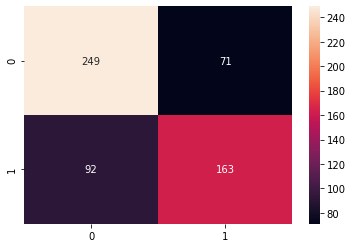

In [225]:
pred = np.array(logresult2.predict(df_test) > 0.5, dtype=float)
confmatrix = np.histogram2d(y_dftest, pred, bins=2)[0]
sns.heatmap(confmatrix, annot = True, fmt='g')